## 实验4 LSTM

### 构造数据  

In [42]:
import numpy as np
import torch  
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt  
from torch.utils.data import DataLoader,Dataset  
#随机生成足够多的八位二进制数  
def generate_number(num=100000):
    a = np.random.randint(0, 128,num)
    b = np.random.randint(0, 128,num)
    sum_ab = a + b
    return [[list(map(int,np.binary_repr(i,8))),list(map(int,np.binary_repr(u,8))),list(map(int,np.binary_repr(k,8)))] for i,u,k in zip(a,b,sum_ab)]


### LSTM 的基本结构

LSTM 单元主要包括三个门：遗忘门、输入门、输出门，以及细胞状态和隐藏状态

#### 1. 遗忘门 (Forget Gate)

遗忘门决定了当前细胞状态应该遗忘多少信息。其公式为：

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

- $ f_t $：遗忘门的输出
- $ \sigma $：sigmoid 激活函数
- $ W_f $：遗忘门的权重矩阵
- $ h_{t-1} $：上一个时刻的隐藏状态
- $ x_t $：当前输入
- $ b_f $：遗忘门的偏置

#### 2. 输入门 (Input Gate)

输入门决定了当前输入将对细胞状态的更新程度。其公式为：

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

- $ i_t $：输入门的输出
- $ W_i $：输入门的权重矩阵
- $ b_i $：输入门的偏置

#### 3. 细胞状态候选 (Cell State Candidate)

细胞状态候选值用于更新细胞状态，其公式为：

$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

- $ \tilde{C}_t $：细胞状态候选
- $ W_C $：细胞状态候选的权重矩阵
- $ b_C $：细胞状态候选的偏置

#### 4. 更新细胞状态 (Cell State Update)

更新细胞状态的公式为：

$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

- $ C_t $：当前细胞状态
- $ C_{t-1} $：上一个时刻的细胞状态

#### 5. 输出门 (Output Gate)

输出门决定了当前细胞状态的哪些部分将被输出。其公式为：

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

- $ o_t $：输出门的输出
- $ W_o $：输出门的权重矩阵
- $ b_o $：输出门的偏置

#### 6. 隐藏状态 (Hidden State)

最终的隐藏状态通过细胞状态和输出门计算得出：

$$
h_t = o_t \cdot \tanh(C_t)
$$

- $ h_t $：当前隐藏状态

### 总结  

- **输入门** $i_t$ 决定哪些新信息将被存储在细胞状态中。
- **遗忘门** $f_t$ 决定哪些信息将被丢弃。
- **输出门** $o_t$ 决定哪些信息将从细胞状态中输出，形成当前的隐藏状态 $h_t$。  

In [43]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,output_size=8):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size  
        #遗忘门的参数定义  
        self.U_i = nn.Parameter(torch.Tensor(self.input_size, self.hidden_size))
        self.V_i = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(self.hidden_size))
        #输入门的参数定义  
        self.U_f = nn.Parameter(torch.Tensor(self.input_size, self.hidden_size))
        self.V_f = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(self.hidden_size))
        #细胞状态候选值的参数  
        self.U_c = nn.Parameter(torch.Tensor(self.input_size, self.hidden_size))
        self.V_c = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(self.hidden_size))
        #输出门的参数  
        self.U_o = nn.Parameter(torch.Tensor(self.input_size, self.hidden_size))
        self.V_o = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(self.hidden_size))  
        self.output_layer = nn.Linear(hidden_size, output_size)#没有添加输出层的话效果不太好
        self.init_weights()
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    def forward(self, x):
        batch_size, time_step, _ = x.size()
        h_t, c_t = (
            torch.zeros(batch_size, self.hidden_size).to(x.device),
            torch.zeros(batch_size, self.hidden_size).to(x.device)
        )
        for t in range(time_step):
            x_t = x[:, t, :]
            #遗忘门的输出
            i_t = torch.sigmoid(x_t @ self.U_i+ h_t @ self.V_i + self.b_i)
            #输入门的输出
            f_t = torch.sigmoid(x_t @ self.U_f+ h_t @ self.V_f + self.b_f)
            #候选细胞状态
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            #输出门的输出  
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            #利用候选细胞状态和上一个细胞状态更新细胞状态
            c_t = f_t * c_t + i_t * g_t
            #计算得到最终的隐藏状态  
            h_t = o_t * torch.tanh(c_t)
        return self.output_layer(h_t)

### 训练部分  

In [44]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  #输入 训练样本数目*2*8  
        self.labels = labels #加法结果  训练样本数目*8  
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [45]:
#划分训练集，测试集    
data=generate_number()
train_data=data[:80000]
test_data=data[80000:]
train_x=torch.tensor(train_data,dtype=torch.float32)[:,:2,:]
train_y=torch.tensor(train_data,dtype=torch.float32)[:,-1:,:]  
train_set=MyDataset(train_x,train_y.reshape(train_y.shape[0],8))
test_x=torch.tensor(test_data,dtype=torch.float32)[:,:2,:]
test_y=torch.tensor(test_data,dtype=torch.float32)[:,-1:,:]  
test_set=MyDataset(test_x,test_y.reshape(test_y.shape[0],8))
#定义模型  
model=LSTM(8,32,8)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)  
train_loader=DataLoader(train_set,batch_size=64)  
def get_test_acc():
    pred=model(test_x)
    acc_num=0
    for p,r in zip(pred,test_y.reshape(test_y.shape[0],8)):
        if p.round().detach().numpy().tolist()==r.numpy().tolist():
            acc_num+=1
    return acc_num/20000
#训练
epoch_num=50
all_loss=[]
acc_list=[]
for epoch in tqdm(range(epoch_num)):
    tmp_loss=[]
    for batch,label in train_loader:
        optimizer.zero_grad()
        outputs=model(batch)
        loss=criterion(outputs,label)  
        loss.backward()
        optimizer.step()  
        tmp_loss.append(float(loss))
    all_loss.append(float(np.array(tmp_loss).mean()))
    acc_list.append(get_test_acc())

100%|██████████| 50/50 [03:27<00:00,  4.15s/it]


In [ ]:
import matplotlib.pyplot as plt 

### 损失随训练变化曲线  

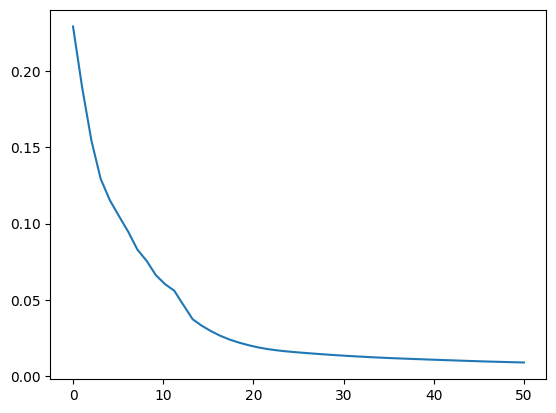

In [48]:
plt.plot(np.linspace(0,len(all_loss),len(all_loss)),all_loss)

### 在验证集上的准确率随训练变化曲线

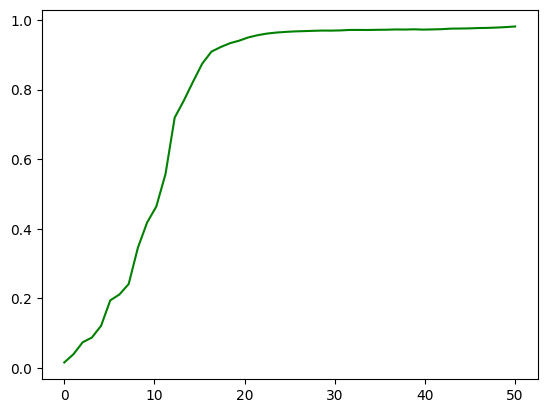

In [51]:
plt.plot(np.linspace(0,len(acc_list),len(acc_list)),acc_list,c='g')